# 9.7. 序列到序列学习（seq2seq）

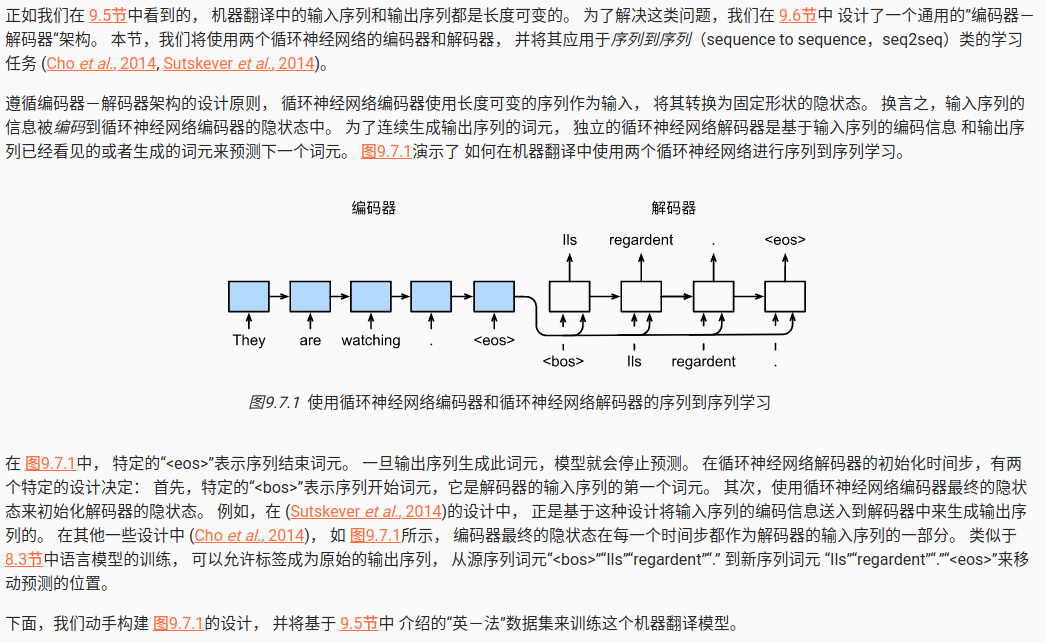

In [1]:
import collections
import math
import torch
from torch import nn
from d2l import torch as d2l

# 9.7.1. 编码器

现在，让我们实现循环神经网络编码器。 注意，我们使用了嵌入层（embedding layer） 来获得输入序列中每个词元的特征向量。 嵌入层的权重是一个矩阵， 其行数等于输入词表的大小（vocab_size）， 其列数等于特征向量的维度（embed_size）。 对于任意输入词元的索引i， 嵌入层获取权重矩阵的第i行（从0开始）以返回其特征向量。 另外，本文选择了一个多层门控循环单元来实现编码器。

多了一步词元向量转为特征向量的操作，因为单纯按照词元向量忽略了不同单词之间的联系？嵌入层类似一个向量映射器，转换维度

In [2]:
#@save
class Seq2SeqEncoder(d2l.Encoder):
    """用于序列到序列学习的循环神经网络编码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        # 嵌入层
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers,
                          dropout=dropout)

    def forward(self, X, *args):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X)
        # 在循环神经网络模型中，第一个轴对应于时间步.维度换位permute函数: (num_steps,batch_size,embed_size)
        X = X.permute(1, 0, 2)
        # 如果未提及状态，则默认为0
        output, state = self.rnn(X)
        # output的形状:(num_steps,batch_size,num_hiddens)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [3]:
"""
class Seq2SeqEncoder(d2l.Encoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqEncoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
        
    def forward(self, X, *args):
        X = self.embedding(X)
        X = X.permute(1, 0, 2)
        output, state = staticmethod.rnn(X)
        return output, state
"""

'\nclass Seq2SeqEncoder(d2l.Encoder):\n    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,\n                 dropout=0, **kwargs):\n        super(Seq2SeqEncoder, self).__init__(**kwargs)\n        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_size)\n        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)\n        \n    def forward(self, X, *args):\n        X = self.embedding(X)\n        X = X.permute(1, 0, 2)\n        output, state = staticmethod.rnn(X)\n        return output, state\n'

下面，我们实例化上述编码器的实现： 我们使用一个两层门控循环单元编码器，其隐藏单元数为16。 给定一小批量的输入序列X（批量大小为4，时间步为7）。 在完成所有时间步后， 最后一层的隐状态的输出是一个张量（output由编码器的循环层返回）， 其形状为（时间步数，批量大小，隐藏单元数）。

In [4]:
encoder = Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
encoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)
output, state = encoder(X)
output.shape

torch.Size([7, 4, 16])

In [5]:
state.shape    # 最后一个时间步的多层隐状态的形状是 （隐藏层的数量，批量大小，隐藏单元的数量）

torch.Size([2, 4, 16])

# 9.7.2. 解码器

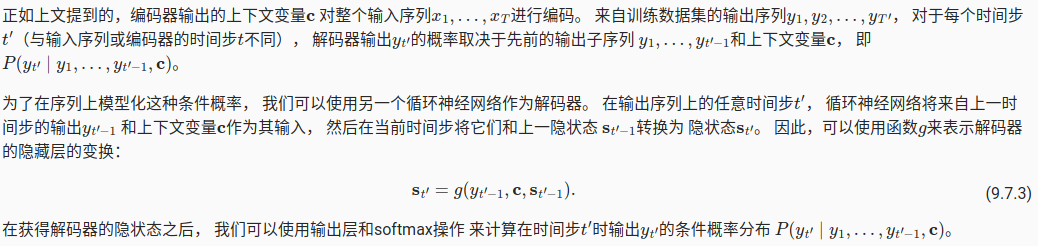  

根据 图9.7.1，当实现解码器时， 我们直接使用编码器最后一个时间步的隐状态来初始化解码器的隐状态。 这就要求使用循环神经网络实现的编码器和解码器具有相同数量的层和隐藏单元。 为了进一步包含经过编码的输入序列的信息， 上下文变量在所有的时间步与解码器的输入进行拼接（concatenate）。 为了预测输出词元的概率分布， 在循环神经网络解码器的最后一层使用全连接层来变换隐状态。  
1. 输入维度从特征向量维度添加了上下文变量，变为embed_size + num_hiddens  
2. 输出需要经过一个线性层  
3. 广播context(state[-1])，使其具有与X相同的num_steps ?

In [6]:
class Seq2SeqDecoder(d2l.Decoder):
    """用于序列到序列学习的循环神经网络解码器"""
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqDecoder, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, *args):
        return enc_outputs[1]

    def forward(self, X, state):
        # 输出'X'的形状：(batch_size,num_steps,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        # 输出'X'的形状：(num_steps,batch_size,embed_size)
        
        # state = [H, C] or [H, ] GRU => [H, ] size:(num_layers,batch_size,num_hiddens)
        # 广播context，使其具有与X相同的num_steps
        context = state[-1].repeat(X.shape[0], 1, 1)
        X_and_context = torch.cat((X, context), 2)
        output, state = self.rnn(X_and_context, state)
        output = self.dense(output).permute(1, 0, 2)
        # output的形状:(batch_size,num_steps,vocab_size)
        # state的形状:(num_layers,batch_size,num_hiddens)
        return output, state

In [7]:
decoder = Seq2SeqDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                         num_layers=2)
decoder.eval()
state = decoder.init_state(encoder(X))
output, state = decoder(X, state)
output.shape, state.shape

(torch.Size([4, 7, 10]), torch.Size([2, 4, 16]))

# 9.7.3. 损失函数  

在每个时间步，解码器预测了输出词元的概率分布。 类似于语言模型，可以使用softmax来获得分布， 并通过计算交叉熵损失函数来进行优化。 回想一下 9.5节中， 特定的填充词元被添加到序列的末尾， 因此不同长度的序列可以以相同形状的小批量加载。 但是，我们应该将填充词元的预测排除在损失函数的计算之外。

为此，我们可以使用下面的sequence_mask函数 通过零值化屏蔽不相关的项， 以便后面任何不相关预测的计算都是与零的乘积，结果都等于零。 例如，如果两个序列的有效长度（不包括填充词元）分别为1和2， 则第一个序列的第一项和第二个序列的前两项之后的剩余项将被清除为零。

In [8]:
#@save
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

X = torch.tensor([[1, 2, 3], [4, 5, 6]])
sequence_mask(X, torch.tensor([1, 2]))

tensor([[1, 0, 0],
        [4, 5, 0]])

In [9]:
# 可以使用此函数屏蔽最后几个轴上的所有项。如果愿意，也可以使用指定的非零值来替换这些项。
X = torch.ones(2, 3, 4)
sequence_mask(X, torch.tensor([1, 2]), value=-1)

tensor([[[ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.],
         [-1., -1., -1., -1.]],

        [[ 1.,  1.,  1.,  1.],
         [ 1.,  1.,  1.,  1.],
         [-1., -1., -1., -1.]]])

现在，我们可以通过扩展softmax交叉熵损失函数来遮蔽不相关的预测。 最初，所有预测词元的掩码都设置为1。 一旦给定了有效长度，与填充词元对应的掩码将被设置为0。 最后，将所有词元的损失乘以掩码，以过滤掉损失中填充词元产生的不相关预测。

1. 继承nn.CrossEntropyLoss，也需要初始化__init__和forward函数  
2. 继承MaskedSoftmaxCELoss的forward函数计算loss后遮蔽
3. 最终loss求均值后返回

In [10]:
#@save
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    """带遮蔽的softmax交叉熵损失函数"""
    # pred的形状：(batch_size,num_steps,vocab_size)
    # label的形状：(batch_size,num_steps)
    # valid_len的形状：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = sequence_mask(weights, valid_len)
        self.reduction='none'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        # print(unweighted_loss)
        weighted_loss = (unweighted_loss * weights).mean(dim=1)
        # print(weighted_loss)
        return weighted_loss

In [11]:
loss = MaskedSoftmaxCELoss()
loss(torch.randn(3, 4, 10), torch.ones((3, 4), dtype=torch.long),
     torch.tensor([4, 2, 0]))

tensor([1.9354, 0.6725, 0.0000])

# 9.7.4. 训练  

在下面的循环训练过程中，如 图9.7.1所示， 特定的序列开始词元（“<bos>”）和 原始的输出序列（不包括序列结束词元“<eos>”） 拼接在一起作为解码器的输入。 这被称为强制教学（teacher forcing）， 因为原始的输出序列（词元的标签）被送入解码器。 或者，将来自上一个时间步的预测得到的词元作为解码器的当前输入。

In [12]:
#@save
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])

    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                     xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                          device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)  # 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()      # 损失函数的标量进行“反向传播”
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
        f'tokens/sec on {str(device)}')

loss 0.020, 15099.0 tokens/sec on cuda:0


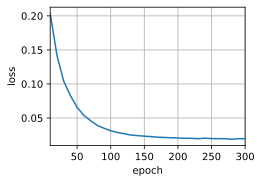

In [13]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 300, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
decoder = Seq2SeqDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers,
                        dropout)
net = d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

# 9.7.5. 预测

In [14]:
#@save
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

# 9.7.6. 预测序列的评估

In [15]:
def bleu(pred_seq, label_seq, k):  #@save
    """计算BLEU"""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, k + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [16]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device)
    print(f'{eng} => {translation}, bleu {bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est mouillé ., bleu 0.658
i'm home . => je suis <unk> !, bleu 0.418


# 9.7.7. 小结

- 根据“编码器-解码器”架构的设计， 我们可以使用两个循环神经网络来设计一个序列到序列学习的模型。

- 在实现编码器和解码器时，我们可以使用多层循环神经网络。

- 我们可以使用遮蔽来过滤不相关的计算，例如在计算损失时。

- 在“编码器－解码器”训练中，强制教学方法将原始输出序列（而非预测结果）输入解码器。

- BLEU是一种常用的评估方法，它通过测量预测序列和标签序列之间的元语法的匹配度来评估预测。

# 9.7.8. 练习